In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('Combined_Data_with_Voltages.csv', index_col=0)
df = df[['FT_Voltage1', 'FT_Voltage2', 'DN_Voltage1', 'DN_Voltage2']]
df

,FT_Voltage1,FT_Voltage2,DN_Voltage1,DN_Voltage2
DateTime,,,,
2022-01-10 00:00:00,0.0,0.0,0.0,0.0
2022-01-10 00:01:00,0.0,0.0,0.0,0.0
2022-01-10 00:02:00,0.0,0.0,0.0,0.0
2022-01-10 00:03:00,0.0,0.0,0.0,0.0
2022-01-10 00:04:00,0.0,0.0,0.0,0.0
...,...,...,...,...
2022-04-19 23:55:00,0.0,0.0,0.0,0.0
2022-04-19 23:56:00,0.0,0.0,0.0,0.0
2022-04-19 23:57:00,0.0,0.0,0.0,0.0


In [3]:
# Case 1: For a single column using variable col
col = 'FT_Voltage1'
data_col = df[col].values

# Case 2: Both columns with prefix FT
ft_cols = [col for col in df.columns if col.startswith('FT_')]
data_ft = df[ft_cols].values

# Case 3: Both columns with prefix DN
dn_cols = [col for col in df.columns if col.startswith('DN_')]
data_dn = df[dn_cols].values

# Case 4: Both voltage1
voltage1_cols = [col for col in df.columns if col.endswith('Voltage1')]
data_voltage1 = df[voltage1_cols].values

# Case 5: Both voltage2
voltage2_cols = [col for col in df.columns if col.endswith('Voltage2')]
data_voltage2 = df[voltage2_cols].values

In [4]:
# train_size = int(0.8 * len(data))  # 80% for training, 20% for testing
# train_data = data[:train_size]
# test_data = data[train_size:]

# Do train test split for each case separately under different variables
case1_train_size = int(0.8 * len(data_col))
case1_train_data = data_col[:case1_train_size]
case1_test_data = data_col[case1_train_size:]

case2_train_size = int(0.8 * len(data_ft))
case2_train_data = data_ft[:case2_train_size]
case2_test_data = data_ft[case2_train_size:]

case3_train_size = int(0.8 * len(data_dn))
case3_train_data = data_dn[:case3_train_size]
case3_test_data = data_dn[case3_train_size:]

case4_train_size = int(0.8 * len(data_voltage1))
case4_train_data = data_voltage1[:case4_train_size]
case4_test_data = data_voltage1[case4_train_size:]

case5_train_size = int(0.8 * len(data_voltage2))
case5_train_data = data_voltage2[:case5_train_size]
case5_test_data = data_voltage2[case5_train_size:]

In [5]:
from sklearn.preprocessing import MinMaxScaler
# Perform min-max scaling on each case separately

# Case 1

case1_scaler = MinMaxScaler()
case1_scaler.fit(case1_train_data.reshape(-1, 1))

case1_train_data = case1_scaler.transform(case1_train_data.reshape(-1, 1))
case1_test_data = case1_scaler.transform(case1_test_data.reshape(-1, 1))

# Case 2

case2_scaler = MinMaxScaler()
case2_scaler.fit(case2_train_data)

case2_train_data = case2_scaler.transform(case2_train_data)
case2_test_data = case2_scaler.transform(case2_test_data)

# Case 3

case3_scaler = MinMaxScaler()
case3_scaler.fit(case3_train_data)

case3_train_data = case3_scaler.transform(case3_train_data)
case3_test_data = case3_scaler.transform(case3_test_data)

# Case 4

case4_scaler = MinMaxScaler()
case4_scaler.fit(case4_train_data)

case4_train_data = case4_scaler.transform(case4_train_data)
case4_test_data = case4_scaler.transform(case4_test_data)

# Case 5

case5_scaler = MinMaxScaler()
case5_scaler.fit(case5_train_data)

case5_train_data = case5_scaler.transform(case5_train_data)
case5_test_data = case5_scaler.transform(case5_test_data)

In [6]:
def create_autoregressive_features(data, lag):
    X = []
    y = []
    for i in range(lag, len(data)):
        X.append(data[i-lag:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Create autoregressive features for each case separately using lag = 60

# Case 1

case1_lag = 60
case1_X_train, case1_y_train = create_autoregressive_features(case1_train_data, case1_lag)
case1_X_test, case1_y_test = create_autoregressive_features(case1_test_data, case1_lag)

# Case 2

case2_lag = 60
case2_X_train, case2_y_train = create_autoregressive_features(case2_train_data, case2_lag)
case2_X_test, case2_y_test = create_autoregressive_features(case2_test_data, case2_lag)

# Case 3

case3_lag = 60
case3_X_train, case3_y_train = create_autoregressive_features(case3_train_data, case3_lag)
case3_X_test, case3_y_test = create_autoregressive_features(case3_test_data, case3_lag)

# Case 4

case4_lag = 60
case4_X_train, case4_y_train = create_autoregressive_features(case4_train_data, case4_lag)
case4_X_test, case4_y_test = create_autoregressive_features(case4_test_data, case4_lag)

# Case 5

case5_lag = 60
case5_X_train, case5_y_train = create_autoregressive_features(case5_train_data, case5_lag)
case5_X_test, case5_y_test = create_autoregressive_features(case5_test_data, case5_lag)

In [7]:
class LSTMForecastModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMForecastModel, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input):
        output, _ = self.lstm(input)
        output = self.fc(output[-1])
        return output
    
# Create LSTM model for each case separately

# Case 1

case1_input_size = 1
case1_hidden_size = 64
case1_output_size = 1

case1_model = LSTMForecastModel(case1_input_size, case1_hidden_size, case1_output_size)

# Case 2

case2_input_size = 2
case2_hidden_size = 64
case2_output_size = 2

case2_model = LSTMForecastModel(case2_input_size, case2_hidden_size, case2_output_size)

# Case 3

case3_input_size = 2
case3_hidden_size = 64
case3_output_size = 2

case3_model = LSTMForecastModel(case3_input_size, case3_hidden_size, case3_output_size)

# Case 4

case4_input_size = 2
case4_hidden_size = 64
case4_output_size = 2

case4_model = LSTMForecastModel(case4_input_size, case4_hidden_size, case4_output_size)

# Case 5

case5_input_size = 2
case5_hidden_size = 64
case5_output_size = 2

case5_model = LSTMForecastModel(case5_input_size, case5_hidden_size, case5_output_size)

In [8]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move the model to CUDA device
case1_model = case1_model.to(device)

# Define loss function and optimizer common for all cases
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(case1_model.parameters(), lr=0.001)

# Case 1

case1_num_epochs = 100
case1_batch_size = 64

# Move data to CUDA device and update data type
case1_X_train = torch.from_numpy(case1_X_train).type(torch.Tensor).to(device)
case1_y_train = torch.from_numpy(case1_y_train).type(torch.Tensor).to(device)
case1_X_test = torch.from_numpy(case1_X_test).type(torch.Tensor).to(device)
case1_y_test = torch.from_numpy(case1_y_test).type(torch.Tensor).to(device)

case1_train = torch.utils.data.TensorDataset(case1_X_train, case1_y_train)
case1_test = torch.utils.data.TensorDataset(case1_X_test, case1_y_test)

case1_train_loader = torch.utils.data.DataLoader(dataset=case1_train, batch_size=case1_batch_size, shuffle=False)
case1_test_loader = torch.utils.data.DataLoader(dataset=case1_test, batch_size=case1_batch_size, shuffle=False)

case1_train_loss = []
case1_test_loss = []

for epoch in range(case1_num_epochs):
    case1_running_loss = 0.0
    case1_running_test_loss = 0.0

    for i, (inputs, labels) in tqdm(enumerate(case1_train_loader)):
        optimizer.zero_grad()

        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case1_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        case1_running_loss += loss.item()

    case1_train_loss.append(case1_running_loss / len(case1_train_loader))

    for i, (inputs, labels) in tqdm(enumerate(case1_test_loader)):
        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case1_model(inputs)

        loss = criterion(outputs, labels)

        case1_running_test_loss += loss.item()

    case1_test_loss.append(case1_running_test_loss / len(case1_test_loader))

    if epoch % 10 == 0:
        print('Epoch: {} | Train Loss: {} | Test Loss: {}'.format(epoch + 1, round(case1_train_loss[-1],6), round(case1_test_loss[-1],6)))


1800it [00:03, 492.82it/s]
450it [00:00, 1076.13it/s]


Epoch: 1 | Train Loss: 0.01267 | Test Loss: 0.000269


1800it [00:03, 532.54it/s]
450it [00:00, 861.53it/s] 
1800it [00:03, 534.74it/s]
450it [00:00, 1065.15it/s]
1800it [00:03, 533.57it/s]
450it [00:00, 1026.62it/s]
1800it [00:03, 528.97it/s]
450it [00:00, 1058.33it/s]
1800it [00:03, 526.33it/s]
450it [00:00, 1044.41it/s]
1800it [00:03, 521.10it/s]
450it [00:00, 1039.39it/s]
1800it [00:03, 514.00it/s]
450it [00:00, 1074.38it/s]
1800it [00:04, 436.34it/s]
450it [00:00, 1068.93it/s]
1800it [00:03, 500.30it/s]
450it [00:00, 1071.37it/s]
1800it [00:03, 517.86it/s]
450it [00:00, 1010.23it/s]


Epoch: 11 | Train Loss: 0.000304 | Test Loss: 0.000241


1800it [00:03, 509.97it/s]
450it [00:00, 1028.83it/s]
1800it [00:03, 524.55it/s]
450it [00:00, 1050.56it/s]
1800it [00:03, 524.53it/s]
450it [00:00, 1031.13it/s]
1800it [00:03, 503.20it/s]
450it [00:00, 1008.70it/s]
1800it [00:03, 521.52it/s]
450it [00:00, 1061.09it/s]
1800it [00:03, 527.14it/s]
450it [00:00, 1045.79it/s]
1800it [00:03, 525.37it/s]
450it [00:00, 1065.17it/s]
1800it [00:03, 526.05it/s]
450it [00:00, 1052.28it/s]
1800it [00:03, 519.52it/s]
450it [00:00, 981.19it/s] 
1800it [00:03, 521.06it/s]
450it [00:00, 1036.37it/s]


Epoch: 21 | Train Loss: 0.000255 | Test Loss: 5.7e-05


1800it [00:03, 511.25it/s]
450it [00:00, 1057.23it/s]
1800it [00:03, 524.19it/s]
450it [00:00, 1042.21it/s]
1800it [00:03, 518.00it/s]
450it [00:00, 1045.85it/s]
1800it [00:03, 515.32it/s]
450it [00:00, 1034.32it/s]
1800it [00:03, 508.09it/s]
450it [00:00, 1025.32it/s]
1800it [00:03, 504.20it/s]
450it [00:00, 1006.31it/s]
1800it [00:03, 505.91it/s]
450it [00:00, 1008.28it/s]
1800it [00:03, 504.26it/s]
450it [00:00, 1022.49it/s]
1800it [00:03, 495.10it/s]
450it [00:00, 878.76it/s] 
1800it [00:03, 499.29it/s]
450it [00:00, 1053.60it/s]


Epoch: 31 | Train Loss: 0.000234 | Test Loss: 5.3e-05


1800it [00:03, 516.90it/s]
450it [00:00, 1048.21it/s]
1800it [00:03, 518.80it/s]
450it [00:00, 1030.98it/s]
1800it [00:03, 527.40it/s]
450it [00:00, 1050.72it/s]
1800it [00:03, 498.76it/s]
450it [00:00, 1033.29it/s]
1800it [00:03, 499.46it/s]
450it [00:00, 1016.13it/s]
1800it [00:03, 490.58it/s]
450it [00:00, 1028.24it/s]
1800it [00:03, 497.63it/s]
450it [00:00, 959.46it/s]
1800it [00:03, 486.37it/s]
450it [00:00, 1027.88it/s]
1800it [00:03, 489.60it/s]
450it [00:00, 997.65it/s] 
1800it [00:03, 488.57it/s]
450it [00:00, 1018.11it/s]


Epoch: 41 | Train Loss: 0.00043 | Test Loss: 0.000337


1800it [00:03, 479.16it/s]
450it [00:00, 1023.09it/s]
1800it [00:03, 492.67it/s]
450it [00:00, 1022.58it/s]
1800it [00:03, 485.26it/s]
450it [00:00, 1031.35it/s]
1800it [00:03, 490.55it/s]
450it [00:00, 1027.42it/s]
1800it [00:03, 499.06it/s]
450it [00:00, 1039.45it/s]
1800it [00:03, 534.58it/s]
450it [00:00, 1083.42it/s]
1800it [00:03, 537.24it/s]
450it [00:00, 1071.79it/s]
1800it [00:03, 535.52it/s]
450it [00:00, 1065.61it/s]
1800it [00:03, 532.83it/s]
450it [00:00, 1009.59it/s]
1800it [00:03, 532.54it/s]
450it [00:00, 1066.75it/s]


Epoch: 51 | Train Loss: 0.000322 | Test Loss: 0.00013


1800it [00:03, 528.86it/s]
450it [00:00, 1053.32it/s]
1800it [00:03, 526.07it/s]
450it [00:00, 1005.19it/s]
1800it [00:03, 531.20it/s]
450it [00:00, 1074.34it/s]
1800it [00:03, 501.00it/s]
450it [00:00, 1053.48it/s]
1800it [00:03, 516.33it/s]
450it [00:00, 1026.43it/s]
1800it [00:03, 517.63it/s]
450it [00:00, 1058.21it/s]
1800it [00:03, 523.30it/s]
450it [00:00, 1057.07it/s]
1800it [00:03, 515.99it/s]
450it [00:00, 1054.77it/s]
1800it [00:03, 511.61it/s]
450it [00:00, 1020.28it/s]
1800it [00:03, 507.68it/s]
450it [00:00, 1044.82it/s]


Epoch: 61 | Train Loss: 0.00027 | Test Loss: 5.7e-05


1800it [00:03, 504.83it/s]
450it [00:00, 1033.02it/s]
1800it [00:03, 513.97it/s]
450it [00:00, 1016.14it/s]
1800it [00:03, 506.52it/s]
450it [00:00, 1014.44it/s]
1800it [00:03, 508.09it/s]
450it [00:00, 1028.51it/s]
1800it [00:03, 497.42it/s]
450it [00:00, 1034.26it/s]
1800it [00:03, 509.31it/s]
450it [00:00, 1056.90it/s]
1800it [00:03, 522.45it/s]
450it [00:00, 1026.51it/s]
1800it [00:03, 530.00it/s]
450it [00:00, 1083.79it/s]
1800it [00:03, 538.49it/s]
450it [00:00, 1070.52it/s]
1800it [00:03, 534.36it/s]
450it [00:00, 1066.58it/s]


Epoch: 71 | Train Loss: 0.000262 | Test Loss: 5.3e-05


1800it [00:03, 534.96it/s]
450it [00:00, 1062.33it/s]
1800it [00:03, 470.74it/s]
450it [00:00, 925.03it/s] 
1800it [00:03, 457.53it/s]
450it [00:00, 1015.15it/s]
1800it [00:03, 495.13it/s]
450it [00:00, 1064.25it/s]
1800it [00:03, 521.91it/s]
450it [00:00, 1057.54it/s]
1800it [00:03, 532.78it/s]
450it [00:00, 1065.46it/s]
1800it [00:03, 525.38it/s]
450it [00:00, 1040.10it/s]
1800it [00:03, 525.31it/s]
450it [00:00, 1015.39it/s]
1800it [00:03, 518.90it/s]
450it [00:00, 1056.59it/s]
1800it [00:03, 511.04it/s]
450it [00:00, 992.71it/s] 


Epoch: 81 | Train Loss: 0.000254 | Test Loss: 6.7e-05


1800it [00:03, 524.88it/s]
450it [00:00, 1075.56it/s]
1800it [00:03, 532.80it/s]
450it [00:00, 1076.00it/s]
1800it [00:03, 536.61it/s]
450it [00:00, 1076.07it/s]
1800it [00:03, 527.76it/s]
450it [00:00, 1045.98it/s]
1800it [00:03, 538.57it/s]
450it [00:00, 1087.83it/s]
1800it [00:03, 532.39it/s]
450it [00:00, 1084.20it/s]
1800it [00:03, 539.82it/s]
450it [00:00, 1080.68it/s]
1800it [00:03, 537.24it/s]
450it [00:00, 1074.57it/s]
1800it [00:03, 515.91it/s]
450it [00:00, 1058.14it/s]
1800it [00:03, 527.75it/s]
450it [00:00, 1055.91it/s]


Epoch: 91 | Train Loss: 0.000234 | Test Loss: 6.2e-05


1800it [00:03, 524.16it/s]
450it [00:00, 1062.57it/s]
1800it [00:03, 523.21it/s]
450it [00:00, 1053.49it/s]
1800it [00:03, 520.24it/s]
450it [00:00, 1001.60it/s]
1800it [00:03, 523.27it/s]
450it [00:00, 1036.08it/s]
1800it [00:03, 518.92it/s]
450it [00:00, 1044.06it/s]
1800it [00:03, 500.13it/s]
450it [00:00, 1034.03it/s]
1800it [00:03, 522.75it/s]
450it [00:00, 1058.08it/s]
1800it [00:03, 530.31it/s]
450it [00:00, 1071.45it/s]
1800it [00:03, 515.26it/s]
450it [00:00, 1071.71it/s]


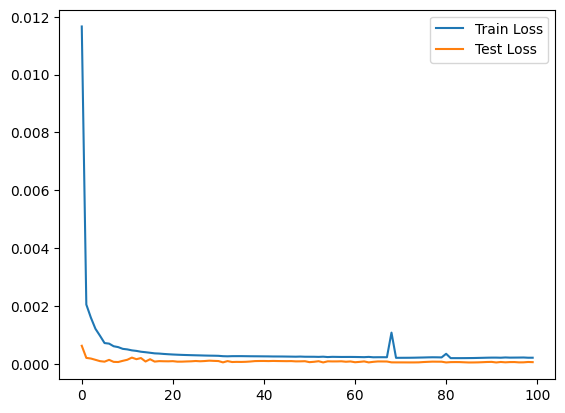

In [14]:
# Plot train and test loss for case 1
plt.figure()
plt.plot(case1_train_loss, label='Train Loss')
plt.plot(case1_test_loss, label='Test Loss')
plt.legend()
plt.show()

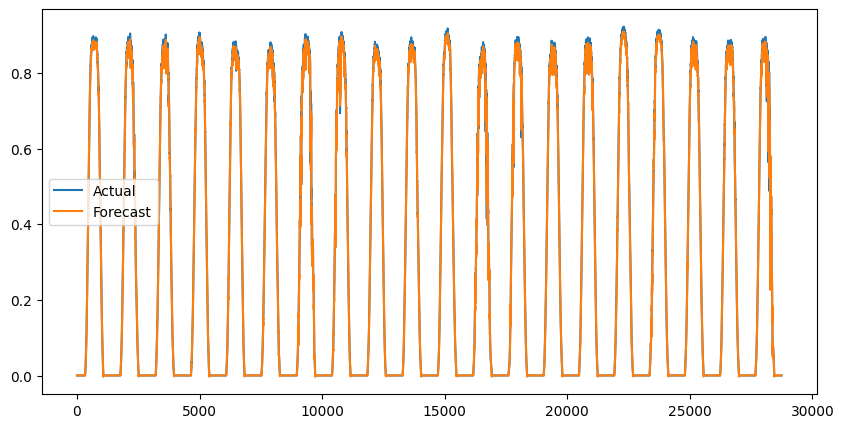

In [9]:
# Plot forecast and actual values for case 1
case1_model.eval()
case1_X_test = case1_X_test.permute(1, 0, 2)
case1_y_pred = case1_model(case1_X_test)
case1_y_pred = case1_y_pred.cpu().detach().numpy()
case1_y_test = case1_y_test.cpu().detach().numpy()

plt.figure(figsize = (10, 5))
plt.plot(case1_y_test, label='Actual')
plt.plot(case1_y_pred, label='Forecast')
plt.legend()
plt.show()

In [11]:
# Clear CUDA cache
torch.cuda.empty_cache()

# Delete variables
del case1_X_train, case1_y_train, case1_X_test, case1_y_test, case1_train, case1_test, case1_train_loader, case1_test_loader, case1_model, case1_running_loss, case1_running_test_loss, case1_y_pred

# Print CUDA memory status
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  17900 KiB |   8962 MiB |  16832 GiB |  16832 GiB |
|       from large pool |  17263 KiB |   8961 MiB |  16384 GiB |  16384 GiB |
|       from small pool |    637 KiB |      2 MiB |    447 GiB |    447 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  17900 KiB |   8962 MiB |  16832 GiB |  16832 GiB |
|       from large pool |  17263 KiB |   8961 MiB |  16384 GiB |

In [12]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to CUDA device
case2_model = case2_model.to(device)

# Define loss function and optimizer common for all cases
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(case2_model.parameters(), lr=0.001)

# Case 2

case2_num_epochs = 100
case2_batch_size = 64

# Move data to CUDA device and update data type
case2_X_train = torch.from_numpy(case2_X_train).type(torch.Tensor).to(device)
case2_y_train = torch.from_numpy(case2_y_train).type(torch.Tensor).to(device)
case2_X_test = torch.from_numpy(case2_X_test).type(torch.Tensor).to(device)
case2_y_test = torch.from_numpy(case2_y_test).type(torch.Tensor).to(device)

case2_train = torch.utils.data.TensorDataset(case2_X_train, case2_y_train)
case2_test = torch.utils.data.TensorDataset(case2_X_test, case2_y_test)

case2_train_loader = torch.utils.data.DataLoader(dataset=case2_train, batch_size=case2_batch_size, shuffle=False)
case2_test_loader = torch.utils.data.DataLoader(dataset=case2_test, batch_size=case2_batch_size, shuffle=False)

case2_train_loss = []
case2_test_loss = []

for epoch in range(case2_num_epochs):
    case2_running_loss = 0.0
    case2_running_test_loss = 0.0

    for i, (inputs, labels) in tqdm(enumerate(case2_train_loader)):
        optimizer.zero_grad()

        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case2_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        case2_running_loss += loss.item()

    case2_train_loss.append(case2_running_loss / len(case2_train_loader))

    for i, (inputs, labels) in tqdm(enumerate(case2_test_loader)):
        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case2_model(inputs)

        loss = criterion(outputs, labels)

        case2_running_test_loss += loss.item()

    case2_test_loss.append(case2_running_test_loss / len(case2_test_loader))

    if epoch % 10 == 0:
        print('Epoch: {} | Train Loss: {} | Test Loss: {}'.format(epoch + 1, round(case2_train_loss[-1],6), round(case2_test_loss[-1],6)))


1800it [00:04, 382.76it/s]
450it [00:00, 999.81it/s] 


Epoch: 1 | Train Loss: 0.009878 | Test Loss: 0.002332


1800it [00:03, 494.61it/s]
450it [00:00, 701.85it/s] 
1800it [00:04, 401.33it/s]
450it [00:00, 1031.84it/s]
1800it [00:04, 400.55it/s]
450it [00:00, 707.78it/s] 
1800it [00:03, 457.91it/s]
450it [00:00, 803.60it/s]
1800it [00:03, 463.48it/s]
450it [00:00, 1011.91it/s]
1800it [00:03, 509.27it/s]
450it [00:00, 916.38it/s] 
1800it [00:03, 510.26it/s]
450it [00:00, 943.35it/s] 
1800it [00:03, 522.23it/s]
450it [00:00, 1060.70it/s]
1800it [00:03, 501.55it/s]
450it [00:00, 1071.61it/s]
1800it [00:03, 529.86it/s]
450it [00:00, 1034.40it/s]


Epoch: 11 | Train Loss: 0.000556 | Test Loss: 0.00015


1800it [00:03, 497.04it/s]
450it [00:00, 1060.75it/s]
1800it [00:03, 528.12it/s]
450it [00:00, 1070.76it/s]
1800it [00:03, 501.77it/s]
450it [00:00, 910.49it/s] 
1800it [00:03, 468.86it/s]
450it [00:00, 1055.36it/s]
1800it [00:03, 499.10it/s]
450it [00:00, 1059.87it/s]
1800it [00:03, 514.35it/s]
450it [00:00, 1049.79it/s]
1800it [00:03, 499.03it/s]
450it [00:00, 1059.16it/s]
1800it [00:03, 523.31it/s]
450it [00:00, 763.16it/s]
1800it [00:03, 451.98it/s]
450it [00:00, 727.60it/s]
1800it [00:03, 495.32it/s]
450it [00:00, 1072.98it/s]


Epoch: 21 | Train Loss: 0.00036 | Test Loss: 0.000207


1800it [00:03, 488.33it/s]
450it [00:00, 1061.94it/s]
1800it [00:03, 523.29it/s]
450it [00:00, 920.80it/s] 
1800it [00:04, 399.70it/s]
450it [00:00, 1062.29it/s]
1800it [00:03, 498.56it/s]
450it [00:00, 901.40it/s] 
1800it [00:04, 438.94it/s]
450it [00:00, 1069.69it/s]
1800it [00:03, 528.80it/s]
450it [00:00, 1059.41it/s]
1800it [00:03, 530.44it/s]
450it [00:00, 1082.05it/s]
1800it [00:03, 525.50it/s]
450it [00:00, 1059.93it/s]
1800it [00:03, 525.45it/s]
450it [00:00, 1057.67it/s]
1800it [00:03, 496.43it/s]
450it [00:00, 1063.87it/s]


Epoch: 31 | Train Loss: 0.000312 | Test Loss: 0.000188


1800it [00:03, 485.83it/s]
450it [00:00, 1068.46it/s]
1800it [00:03, 532.60it/s]
450it [00:00, 1079.51it/s]
1800it [00:03, 507.39it/s]
450it [00:00, 1055.35it/s]
1800it [00:03, 526.12it/s]
450it [00:00, 863.32it/s] 
1800it [00:03, 529.81it/s]
450it [00:00, 1042.52it/s]
1800it [00:03, 519.68it/s]
450it [00:00, 680.82it/s]
1800it [00:03, 517.26it/s]
450it [00:00, 1071.22it/s]
1800it [00:03, 527.17it/s]
450it [00:00, 1057.24it/s]
1800it [00:03, 510.72it/s]
450it [00:00, 1075.51it/s]
1800it [00:03, 530.45it/s]
450it [00:00, 1075.57it/s]


Epoch: 41 | Train Loss: 0.00029 | Test Loss: 0.000191


1800it [00:03, 530.62it/s]
450it [00:00, 1071.01it/s]
1800it [00:03, 528.53it/s]
450it [00:00, 1072.63it/s]
1800it [00:03, 529.05it/s]
450it [00:00, 1076.11it/s]
1800it [00:03, 531.96it/s]
450it [00:00, 1072.66it/s]
1800it [00:03, 526.73it/s]
450it [00:00, 1063.67it/s]
1800it [00:03, 490.21it/s]
450it [00:00, 1061.30it/s]
1800it [00:03, 519.11it/s]
450it [00:00, 1049.59it/s]
1800it [00:03, 506.77it/s]
450it [00:00, 1055.55it/s]
1800it [00:04, 447.87it/s]
450it [00:00, 1065.99it/s]
1800it [00:03, 487.37it/s]
450it [00:00, 1068.55it/s]


Epoch: 51 | Train Loss: 0.000257 | Test Loss: 0.000171


1800it [00:03, 535.69it/s]
450it [00:00, 1059.70it/s]
1800it [00:03, 532.54it/s]
450it [00:00, 1070.73it/s]
1800it [00:03, 485.72it/s]
450it [00:00, 848.77it/s]
1800it [00:03, 514.15it/s]
450it [00:00, 773.35it/s] 
1800it [00:03, 520.13it/s]
450it [00:00, 1066.77it/s]
1800it [00:03, 527.26it/s]
450it [00:00, 1062.31it/s]
1800it [00:03, 510.00it/s]
450it [00:00, 1067.92it/s]
1800it [00:03, 490.53it/s]
450it [00:00, 859.19it/s] 
1800it [00:03, 500.50it/s]
450it [00:00, 1044.32it/s]
1800it [00:03, 492.68it/s]
450it [00:00, 1059.07it/s]


Epoch: 61 | Train Loss: 0.001863 | Test Loss: 0.000807


1800it [00:03, 503.71it/s]
450it [00:00, 1027.77it/s]
1800it [00:03, 531.60it/s]
450it [00:00, 1056.65it/s]
1800it [00:03, 528.83it/s]
450it [00:00, 1078.24it/s]
1800it [00:03, 478.94it/s]
450it [00:00, 1065.48it/s]
1800it [00:03, 529.64it/s]
450it [00:00, 1050.60it/s]
1800it [00:03, 522.25it/s]
450it [00:00, 1061.62it/s]
1800it [00:03, 495.69it/s]
450it [00:00, 742.44it/s]
1800it [00:03, 517.53it/s]
450it [00:00, 1042.30it/s]
1800it [00:03, 518.16it/s]
450it [00:00, 1058.72it/s]
1800it [00:03, 503.24it/s]
450it [00:00, 1056.24it/s]


Epoch: 71 | Train Loss: 0.000359 | Test Loss: 0.000264


1800it [00:03, 514.68it/s]
450it [00:00, 1051.51it/s]
1800it [00:03, 494.16it/s]
450it [00:00, 1051.81it/s]
1800it [00:03, 515.36it/s]
450it [00:00, 885.38it/s] 
1800it [00:03, 508.15it/s]
450it [00:00, 1030.89it/s]
1800it [00:03, 517.13it/s]
450it [00:00, 1050.07it/s]
1800it [00:03, 521.08it/s]
450it [00:00, 1053.72it/s]
1800it [00:03, 520.39it/s]
450it [00:00, 1091.31it/s]
1800it [00:03, 536.39it/s]
450it [00:00, 1081.27it/s]
1800it [00:03, 523.17it/s]
450it [00:00, 1080.75it/s]
1800it [00:03, 525.76it/s]
450it [00:00, 1058.73it/s]


Epoch: 81 | Train Loss: 0.000284 | Test Loss: 0.000301


1800it [00:03, 490.14it/s]
450it [00:00, 931.09it/s] 
1800it [00:03, 490.59it/s]
450it [00:00, 700.38it/s]
1800it [00:03, 491.56it/s]
450it [00:00, 1052.60it/s]
1800it [00:03, 517.36it/s]
450it [00:00, 1065.41it/s]
1800it [00:03, 523.78it/s]
450it [00:00, 1069.51it/s]
1800it [00:03, 516.09it/s]
450it [00:00, 1052.14it/s]
1800it [00:03, 478.71it/s]
450it [00:00, 1070.89it/s]
1800it [00:03, 530.71it/s]
450it [00:00, 1061.59it/s]
1800it [00:03, 523.68it/s]
450it [00:00, 1038.58it/s]
1800it [00:03, 520.15it/s]
450it [00:00, 1067.96it/s]


Epoch: 91 | Train Loss: 0.000234 | Test Loss: 0.000176


1800it [00:04, 414.00it/s]
450it [00:00, 1061.10it/s]
1800it [00:03, 523.85it/s]
450it [00:00, 900.71it/s] 
1800it [00:03, 505.59it/s]
450it [00:00, 896.10it/s] 
1800it [00:03, 486.45it/s]
450it [00:00, 1044.80it/s]
1800it [00:03, 504.77it/s]
450it [00:00, 1049.66it/s]
1800it [00:03, 482.93it/s]
450it [00:00, 1064.56it/s]
1800it [00:03, 476.74it/s]
450it [00:00, 1014.20it/s]
1800it [00:03, 482.37it/s]
450it [00:00, 1018.39it/s]
1800it [00:03, 485.43it/s]
450it [00:00, 994.70it/s] 


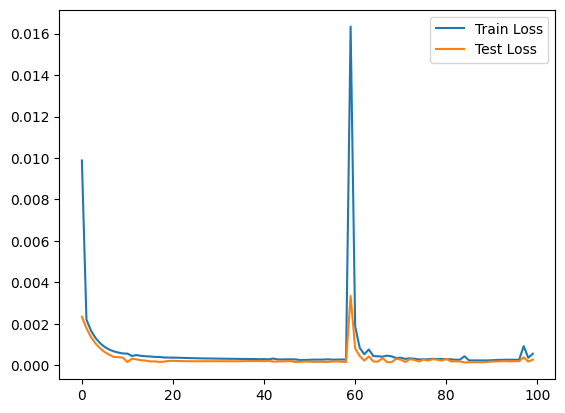

In [13]:
# Plot train and test loss for case 2
plt.figure()
plt.plot(case2_train_loss, label='Train Loss')
plt.plot(case2_test_loss, label='Test Loss')
plt.legend()
plt.show()

In [14]:
# Save model
torch.save(case2_model.state_dict(), 'case2_model.pth')

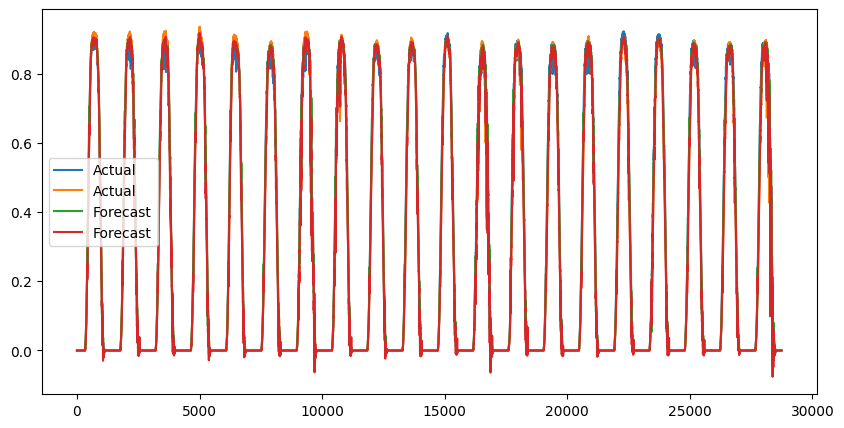

In [15]:
# Plot forecast and actual values for case 2
case2_model.eval()
case2_X_test = case2_X_test.permute(1, 0, 2)
case2_y_pred = case2_model(case2_X_test)
case2_y_pred = case2_y_pred.cpu().detach().numpy()
case2_y_test = case2_y_test.cpu().detach().numpy()

plt.figure(figsize = (10, 5))
plt.plot(case2_y_test, label='Actual')
plt.plot(case2_y_pred, label='Forecast')
plt.legend()
plt.show()

In [16]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to CUDA device
case3_model = case3_model.to(device)

# Define loss function and optimizer common for all cases
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(case3_model.parameters(), lr=0.001)

# Case 3

case3_num_epochs = 100
case3_batch_size = 64

# Move data to CUDA device and update data type
case3_X_train = torch.from_numpy(case3_X_train).type(torch.Tensor).to(device)
case3_y_train = torch.from_numpy(case3_y_train).type(torch.Tensor).to(device)
case3_X_test = torch.from_numpy(case3_X_test).type(torch.Tensor).to(device)
case3_y_test = torch.from_numpy(case3_y_test).type(torch.Tensor).to(device)

case3_train = torch.utils.data.TensorDataset(case3_X_train, case3_y_train)
case3_test = torch.utils.data.TensorDataset(case3_X_test, case3_y_test)

case3_train_loader = torch.utils.data.DataLoader(dataset=case3_train, batch_size=case3_batch_size, shuffle=False)
case3_test_loader = torch.utils.data.DataLoader(dataset=case3_test, batch_size=case3_batch_size, shuffle=False)

case3_train_loss = []
case3_test_loss = []

for epoch in range(case3_num_epochs):
    case3_running_loss = 0.0
    case3_running_test_loss = 0.0

    for i, (inputs, labels) in tqdm(enumerate(case3_train_loader)):
        optimizer.zero_grad()

        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case3_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        case3_running_loss += loss.item()

    case3_train_loss.append(case3_running_loss / len(case3_train_loader))

    for i, (inputs, labels) in tqdm(enumerate(case3_test_loader)):
        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case3_model(inputs)

        loss = criterion(outputs, labels)

        case3_running_test_loss += loss.item()

    case3_test_loss.append(case3_running_test_loss / len(case3_test_loader))

    if epoch % 10 == 0:
        print('Epoch: {} | Train Loss: {} | Test Loss: {}'.format(epoch + 1, round(case3_train_loss[-1], 6), round(case3_test_loss[-1], 6)))


1800it [00:03, 496.64it/s]
450it [00:00, 1058.90it/s]


Epoch: 1 | Train Loss: 0.010159 | Test Loss: 0.001594


1800it [00:03, 526.53it/s]
450it [00:00, 1057.50it/s]
1800it [00:03, 529.51it/s]
450it [00:00, 1065.06it/s]
1800it [00:03, 518.22it/s]
450it [00:00, 1049.83it/s]
1800it [00:03, 520.31it/s]
450it [00:00, 1062.42it/s]
1800it [00:03, 523.82it/s]
450it [00:00, 1052.42it/s]
1800it [00:03, 525.22it/s]
450it [00:00, 1057.12it/s]
1800it [00:03, 524.03it/s]
450it [00:00, 1055.05it/s]
1800it [00:03, 524.25it/s]
450it [00:00, 1055.21it/s]
1800it [00:03, 519.97it/s]
450it [00:00, 1057.81it/s]
1800it [00:03, 523.06it/s]
450it [00:00, 1041.09it/s]


Epoch: 11 | Train Loss: 0.000496 | Test Loss: 0.000178


1800it [00:03, 523.03it/s]
450it [00:00, 1051.74it/s]
1800it [00:03, 521.34it/s]
450it [00:00, 1062.83it/s]
1800it [00:03, 524.88it/s]
450it [00:00, 1058.01it/s]
1800it [00:03, 528.26it/s]
450it [00:00, 1042.49it/s]
1800it [00:03, 488.74it/s]
450it [00:00, 1052.24it/s]
1800it [00:03, 511.12it/s]
450it [00:00, 1049.51it/s]
1800it [00:03, 505.71it/s]
450it [00:00, 1006.64it/s]
1800it [00:04, 448.49it/s]
450it [00:00, 797.12it/s]
1800it [00:04, 432.99it/s]
450it [00:00, 1048.06it/s]
1800it [00:03, 505.58it/s]
450it [00:00, 1045.89it/s]


Epoch: 21 | Train Loss: 0.000368 | Test Loss: 0.000125


1800it [00:03, 518.11it/s]
450it [00:00, 1070.19it/s]
1800it [00:03, 500.57it/s]
450it [00:00, 986.39it/s] 
1800it [00:03, 484.67it/s]
450it [00:00, 1069.35it/s]
1800it [00:03, 529.71it/s]
450it [00:00, 1059.29it/s]
1800it [00:03, 508.95it/s]
450it [00:00, 1069.53it/s]
1800it [00:03, 479.42it/s]
450it [00:00, 667.35it/s] 
1800it [00:03, 487.03it/s]
450it [00:00, 1053.74it/s]
1800it [00:03, 527.88it/s]
450it [00:00, 1070.44it/s]
1800it [00:03, 514.96it/s]
450it [00:00, 848.35it/s] 
1800it [00:03, 452.92it/s]
450it [00:00, 1056.70it/s]


Epoch: 31 | Train Loss: 0.000315 | Test Loss: 0.00018


1800it [00:03, 508.47it/s]
450it [00:00, 754.23it/s]
1800it [00:03, 503.04it/s]
450it [00:00, 1045.63it/s]
1800it [00:04, 449.90it/s]
450it [00:00, 869.55it/s]
1800it [00:03, 498.08it/s]
450it [00:00, 983.22it/s] 
1800it [00:04, 397.25it/s]
450it [00:00, 990.06it/s] 
1800it [00:04, 438.89it/s]
450it [00:00, 1062.62it/s]
1800it [00:03, 521.77it/s]
450it [00:00, 1043.83it/s]
1800it [00:03, 451.93it/s]
450it [00:00, 1048.45it/s]
1800it [00:03, 458.71it/s]
450it [00:00, 1060.71it/s]
1800it [00:03, 456.80it/s]
450it [00:00, 919.63it/s]


Epoch: 41 | Train Loss: 0.000289 | Test Loss: 0.000107


1800it [00:04, 441.33it/s]
450it [00:00, 1064.66it/s]
1800it [00:04, 402.34it/s]
450it [00:00, 882.86it/s] 
1800it [00:03, 454.83it/s]
450it [00:00, 1097.82it/s]
1800it [00:03, 515.38it/s]
450it [00:00, 1080.39it/s]
1800it [00:03, 493.32it/s]
450it [00:00, 957.12it/s] 
1800it [00:04, 431.97it/s]
450it [00:00, 1036.57it/s]
1800it [00:03, 490.13it/s]
450it [00:00, 761.60it/s]
1800it [00:03, 463.02it/s]
450it [00:00, 886.33it/s]
1800it [00:03, 461.66it/s]
450it [00:00, 825.55it/s]
1800it [00:03, 522.03it/s]
450it [00:00, 1051.07it/s]


Epoch: 51 | Train Loss: 0.000267 | Test Loss: 0.000176


1800it [00:03, 521.50it/s]
450it [00:00, 943.38it/s] 
1800it [00:03, 515.06it/s]
450it [00:00, 1072.23it/s]
1800it [00:03, 531.02it/s]
450it [00:00, 983.50it/s] 
1800it [00:03, 506.63it/s]
450it [00:00, 745.76it/s] 
1800it [00:03, 514.45it/s]
450it [00:00, 895.41it/s] 
1800it [00:03, 497.41it/s]
450it [00:00, 1062.27it/s]
1800it [00:03, 466.55it/s]
450it [00:00, 1064.74it/s]
1800it [00:03, 530.46it/s]
450it [00:00, 1067.72it/s]
1800it [00:03, 504.34it/s]
450it [00:00, 1076.62it/s]
1800it [00:04, 414.47it/s]
450it [00:00, 789.49it/s] 


Epoch: 61 | Train Loss: 0.000237 | Test Loss: 9.9e-05


1800it [00:03, 482.35it/s]
450it [00:00, 747.96it/s] 
1800it [00:04, 447.30it/s]
450it [00:00, 907.89it/s] 
1800it [00:03, 488.62it/s]
450it [00:00, 903.84it/s] 
1800it [00:04, 382.30it/s]
450it [00:00, 668.57it/s]
1800it [00:03, 450.08it/s]
450it [00:00, 835.00it/s] 
1800it [00:03, 477.68it/s]
450it [00:00, 1060.50it/s]
1800it [00:03, 513.90it/s]
450it [00:00, 517.58it/s]
1800it [00:03, 510.53it/s]
450it [00:00, 1062.07it/s]
1800it [00:03, 516.48it/s]
450it [00:00, 642.84it/s]
1800it [00:03, 479.37it/s]
450it [00:00, 965.89it/s] 


Epoch: 71 | Train Loss: 0.000239 | Test Loss: 0.000153


1800it [00:03, 485.87it/s]
450it [00:00, 785.18it/s]
1800it [00:04, 386.94it/s]
450it [00:00, 1247.74it/s]
1800it [00:04, 367.61it/s]
450it [00:00, 1239.67it/s]
1800it [00:05, 357.16it/s]
450it [00:00, 1250.54it/s]
1800it [00:05, 357.89it/s]
450it [00:00, 1248.00it/s]
1800it [00:05, 357.88it/s]
450it [00:00, 1238.62it/s]
1800it [00:05, 358.88it/s]
450it [00:00, 1245.70it/s]
1800it [00:04, 360.35it/s]
450it [00:00, 1246.04it/s]
1800it [00:05, 357.02it/s]
450it [00:00, 1247.76it/s]
1800it [00:05, 357.16it/s]
450it [00:00, 1245.09it/s]


Epoch: 81 | Train Loss: 0.000453 | Test Loss: 0.000105


1800it [00:05, 357.48it/s]
450it [00:00, 1246.89it/s]
1800it [00:04, 360.34it/s]
450it [00:00, 1247.79it/s]
1800it [00:05, 356.95it/s]
450it [00:00, 1246.27it/s]
1800it [00:04, 376.00it/s]
450it [00:00, 1014.33it/s]
1800it [00:04, 376.36it/s]
450it [00:00, 1200.90it/s]
1800it [00:03, 569.56it/s]
450it [00:00, 1150.14it/s]
1800it [00:03, 578.90it/s]
450it [00:00, 1139.97it/s]
1800it [00:03, 576.73it/s]
450it [00:00, 1156.39it/s]
1800it [00:03, 472.03it/s]
450it [00:00, 1243.24it/s]
1800it [00:05, 357.93it/s]
450it [00:00, 1236.10it/s]


Epoch: 91 | Train Loss: 0.000264 | Test Loss: 9.9e-05


1800it [00:04, 376.51it/s]
450it [00:00, 1215.91it/s]
1800it [00:03, 471.12it/s]
450it [00:00, 1150.20it/s]
1800it [00:03, 574.19it/s]
450it [00:00, 1143.02it/s]
1800it [00:03, 575.60it/s]
450it [00:00, 1151.50it/s]
1800it [00:03, 579.77it/s]
450it [00:00, 1148.53it/s]
1800it [00:03, 579.65it/s]
450it [00:00, 1154.52it/s]
1800it [00:03, 578.55it/s]
450it [00:00, 1151.59it/s]
1800it [00:03, 577.66it/s]
450it [00:00, 1149.27it/s]
1800it [00:03, 576.71it/s]
450it [00:00, 1143.53it/s]


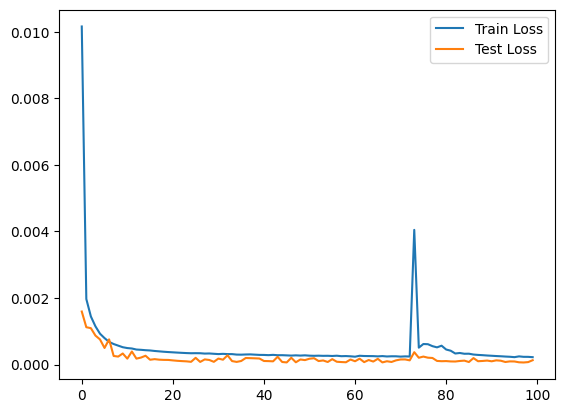

In [17]:
# Plot train and test loss for case 3
plt.figure()
plt.plot(case3_train_loss, label='Train Loss')
plt.plot(case3_test_loss, label='Test Loss')
plt.legend()
plt.show()

In [18]:
# Save model
torch.save(case3_model.state_dict(), 'case3_model.pth')

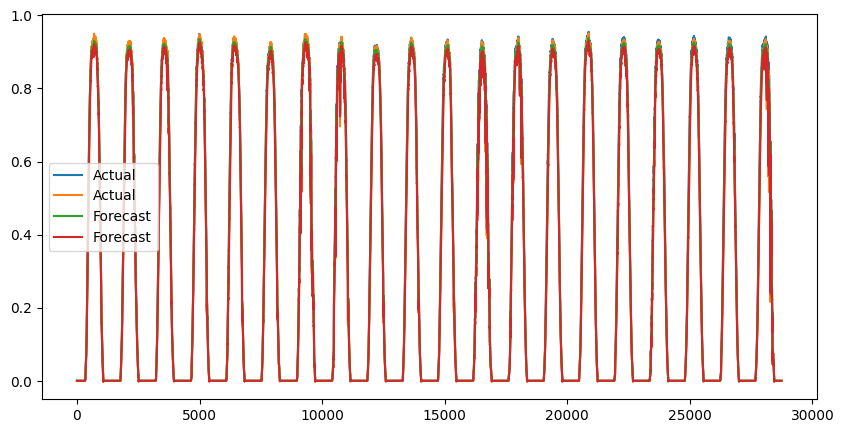

In [21]:
# Plot forecast and actual values for case 3
case3_model.eval()
case3_X_test = case3_X_test.permute(1, 0, 2)
case3_y_pred = case3_model(case3_X_test)
case3_y_pred = case3_y_pred.cpu().detach().numpy()
case3_y_test = case3_y_test.cpu().detach().numpy()

plt.figure(figsize = (10, 5))
plt.plot(case3_y_test, label='Actual')
plt.plot(case3_y_pred, label='Forecast')
plt.legend()
plt.show()

In [23]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to CUDA device
case4_model = case4_model.to(device)

# Define loss function and optimizer common for all cases
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(case4_model.parameters(), lr=0.001)

# Case 4

case4_num_epochs = 100
case4_batch_size = 64

# Move data to CUDA device and update data type
case4_X_train = torch.from_numpy(case4_X_train).type(torch.Tensor).to(device)
case4_y_train = torch.from_numpy(case4_y_train).type(torch.Tensor).to(device)
case4_X_test = torch.from_numpy(case4_X_test).type(torch.Tensor).to(device)
case4_y_test = torch.from_numpy(case4_y_test).type(torch.Tensor).to(device)

case4_train = torch.utils.data.TensorDataset(case4_X_train, case4_y_train)
case4_test = torch.utils.data.TensorDataset(case4_X_test, case4_y_test)

case4_train_loader = torch.utils.data.DataLoader(dataset=case4_train, batch_size=case4_batch_size, shuffle=False)
case4_test_loader = torch.utils.data.DataLoader(dataset=case4_test, batch_size=case4_batch_size, shuffle=False)

case4_train_loss = []
case4_test_loss = []

for epoch in range(case4_num_epochs):
    case4_running_loss = 0.0
    case4_running_test_loss = 0.0

    for i, (inputs, labels) in tqdm(enumerate(case4_train_loader)):
        optimizer.zero_grad()

        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case4_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        case4_running_loss += loss.item()

    case4_train_loss.append(case4_running_loss / len(case4_train_loader))

    for i, (inputs, labels) in tqdm(enumerate(case4_test_loader)):
        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case4_model(inputs)

        loss = criterion(outputs, labels)

        case4_running_test_loss += loss.item()

    case4_test_loss.append(case4_running_test_loss / len(case4_test_loader))

    if epoch % 10 == 0:
        print('Epoch: {} | Train Loss: {} | Test Loss: {}'.format(epoch + 1, round(case4_train_loss[-1], 6), round(case4_test_loss[-1], 6)))


1800it [00:03, 540.77it/s]
450it [00:00, 1167.78it/s]


Epoch: 1 | Train Loss: 0.006172 | Test Loss: 0.000676


1800it [00:03, 582.29it/s]
450it [00:00, 1143.64it/s]
1800it [00:03, 583.76it/s]
450it [00:00, 1162.09it/s]
1800it [00:03, 579.39it/s]
450it [00:00, 1145.35it/s]
1800it [00:03, 578.16it/s]
450it [00:00, 1153.57it/s]
1800it [00:03, 587.45it/s]
450it [00:00, 1166.52it/s]
1800it [00:03, 585.51it/s]
450it [00:00, 1170.45it/s]
1800it [00:03, 581.25it/s]
450it [00:00, 1168.98it/s]
1800it [00:03, 588.37it/s]
450it [00:00, 1168.91it/s]
1800it [00:03, 588.34it/s]
450it [00:00, 1155.07it/s]
1800it [00:03, 474.24it/s]
450it [00:00, 1136.18it/s]


Epoch: 11 | Train Loss: 0.000489 | Test Loss: 0.0002


1800it [00:03, 579.33it/s]
450it [00:00, 1176.40it/s]
1800it [00:03, 582.12it/s]
450it [00:00, 1156.89it/s]
1800it [00:03, 559.98it/s]
450it [00:00, 1152.88it/s]
1800it [00:03, 571.64it/s]
450it [00:00, 1159.04it/s]
1800it [00:03, 585.50it/s]
450it [00:00, 1161.35it/s]
1800it [00:03, 577.34it/s]
450it [00:00, 1155.83it/s]
1800it [00:03, 578.46it/s]
450it [00:00, 1151.09it/s]
1800it [00:03, 564.57it/s]
450it [00:00, 1161.73it/s]
1800it [00:03, 582.61it/s]
450it [00:00, 1156.64it/s]
1800it [00:03, 582.27it/s]
450it [00:00, 1158.27it/s]


Epoch: 21 | Train Loss: 0.000325 | Test Loss: 9.4e-05


1800it [00:03, 579.54it/s]
450it [00:00, 1142.18it/s]
1800it [00:03, 580.82it/s]
450it [00:00, 1154.15it/s]
1800it [00:03, 583.27it/s]
450it [00:00, 1167.14it/s]
1800it [00:03, 581.72it/s]
450it [00:00, 1171.87it/s]
1800it [00:03, 585.64it/s]
450it [00:00, 1162.79it/s]
1800it [00:03, 585.14it/s]
450it [00:00, 1157.09it/s]
1800it [00:03, 582.87it/s]
450it [00:00, 1160.30it/s]
1800it [00:03, 584.33it/s]
450it [00:00, 1162.96it/s]
1800it [00:03, 578.00it/s]
450it [00:00, 1149.54it/s]
1800it [00:03, 576.58it/s]
450it [00:00, 1149.10it/s]


Epoch: 31 | Train Loss: 0.00026 | Test Loss: 0.000219


1800it [00:03, 581.20it/s]
450it [00:00, 1159.82it/s]
1800it [00:03, 583.86it/s]
450it [00:00, 1141.50it/s]
1800it [00:03, 582.62it/s]
450it [00:00, 1155.38it/s]
1800it [00:03, 582.35it/s]
450it [00:00, 1160.67it/s]
1800it [00:03, 583.09it/s]
450it [00:00, 1162.51it/s]
1800it [00:03, 581.77it/s]
450it [00:00, 1145.86it/s]
1800it [00:03, 577.77it/s]
450it [00:00, 1147.01it/s]
1800it [00:03, 533.49it/s]
450it [00:00, 1013.67it/s]
1800it [00:05, 353.87it/s]
450it [00:00, 1214.38it/s]
1800it [00:03, 525.51it/s]
450it [00:00, 1177.27it/s]


Epoch: 41 | Train Loss: 0.00022 | Test Loss: 0.000144


1800it [00:03, 586.70it/s]
450it [00:00, 1158.01it/s]
1800it [00:03, 579.47it/s]
450it [00:00, 1156.69it/s]
1800it [00:03, 578.09it/s]
450it [00:00, 1150.57it/s]
1800it [00:03, 579.18it/s]
450it [00:00, 1158.92it/s]
1800it [00:03, 576.89it/s]
450it [00:00, 1148.34it/s]
1800it [00:03, 574.11it/s]
450it [00:00, 1148.86it/s]
1800it [00:03, 584.35it/s]
450it [00:00, 1140.41it/s]
1800it [00:03, 582.87it/s]
450it [00:00, 1174.95it/s]
1800it [00:03, 581.36it/s]
450it [00:00, 1159.66it/s]
1800it [00:03, 587.60it/s]
450it [00:00, 1171.89it/s]


Epoch: 51 | Train Loss: 0.000212 | Test Loss: 8.9e-05


1800it [00:03, 589.31it/s]
450it [00:00, 1167.91it/s]
1800it [00:03, 585.06it/s]
450it [00:00, 1171.36it/s]
1800it [00:03, 587.52it/s]
450it [00:00, 1167.30it/s]
1800it [00:03, 577.38it/s]
450it [00:00, 1142.09it/s]
1800it [00:03, 576.54it/s]
450it [00:00, 1140.95it/s]
1800it [00:03, 583.23it/s]
450it [00:00, 1172.19it/s]
1800it [00:03, 588.94it/s]
450it [00:00, 1166.71it/s]
1800it [00:03, 587.80it/s]
450it [00:00, 1161.22it/s]
1800it [00:03, 588.00it/s]
450it [00:00, 1170.76it/s]
1800it [00:03, 586.83it/s]
450it [00:00, 1167.04it/s]


Epoch: 61 | Train Loss: 0.0002 | Test Loss: 9e-05


1800it [00:03, 588.40it/s]
450it [00:00, 1154.55it/s]
1800it [00:03, 571.44it/s]
450it [00:00, 1145.98it/s]
1800it [00:03, 582.01it/s]
450it [00:00, 1170.92it/s]
1800it [00:03, 582.82it/s]
450it [00:00, 1154.30it/s]
1800it [00:03, 580.69it/s]
450it [00:00, 1158.32it/s]
1800it [00:03, 556.29it/s]
450it [00:00, 1233.21it/s]
1800it [00:03, 457.70it/s]
450it [00:00, 1146.30it/s]
1800it [00:03, 576.29it/s]
450it [00:00, 920.39it/s] 
1800it [00:03, 575.72it/s]
450it [00:00, 1141.98it/s]
1800it [00:03, 580.54it/s]
450it [00:00, 1155.79it/s]


Epoch: 71 | Train Loss: 0.000197 | Test Loss: 6.1e-05


1800it [00:03, 575.65it/s]
450it [00:00, 1144.16it/s]
1800it [00:03, 516.29it/s]
450it [00:00, 1176.24it/s]
1800it [00:03, 580.10it/s]
450it [00:00, 1151.88it/s]
1800it [00:03, 582.50it/s]
450it [00:00, 1157.74it/s]
1800it [00:04, 429.10it/s]
450it [00:00, 1116.00it/s]
1800it [00:03, 566.35it/s]
450it [00:00, 1157.97it/s]
1800it [00:03, 584.94it/s]
450it [00:00, 1144.46it/s]
1800it [00:03, 588.38it/s]
450it [00:00, 1168.77it/s]
1800it [00:03, 581.66it/s]
450it [00:00, 1143.28it/s]
1800it [00:03, 574.80it/s]
450it [00:00, 1145.11it/s]


Epoch: 81 | Train Loss: 0.000193 | Test Loss: 9.4e-05


1800it [00:03, 575.18it/s]
450it [00:00, 1161.73it/s]
1800it [00:03, 585.05it/s]
450it [00:00, 1156.07it/s]
1800it [00:03, 579.16it/s]
450it [00:00, 1158.45it/s]
1800it [00:03, 580.81it/s]
450it [00:00, 1153.21it/s]
1800it [00:03, 580.57it/s]
450it [00:00, 1157.89it/s]
1800it [00:03, 580.34it/s]
450it [00:00, 1156.07it/s]
1800it [00:03, 579.48it/s]
450it [00:00, 1148.32it/s]
1800it [00:03, 577.57it/s]
450it [00:00, 1147.85it/s]
1800it [00:03, 581.30it/s]
450it [00:00, 1157.43it/s]
1800it [00:03, 515.50it/s]
450it [00:00, 961.28it/s] 


Epoch: 91 | Train Loss: 0.000179 | Test Loss: 5.7e-05


1800it [00:03, 572.84it/s]
450it [00:00, 1075.33it/s]
1800it [00:03, 582.65it/s]
450it [00:00, 829.27it/s] 
1800it [00:03, 536.00it/s]
450it [00:00, 972.81it/s] 
1800it [00:03, 532.93it/s]
450it [00:00, 1133.02it/s]
1800it [00:03, 555.82it/s]
450it [00:00, 864.76it/s] 
1800it [00:03, 542.49it/s]
450it [00:00, 1068.19it/s]
1800it [00:03, 540.15it/s]
450it [00:00, 1169.55it/s]
1800it [00:04, 383.59it/s]
450it [00:00, 932.99it/s] 
1800it [00:03, 578.47it/s]
450it [00:00, 1160.19it/s]


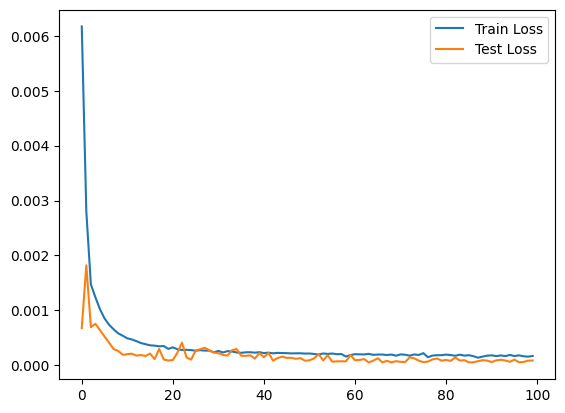

In [24]:
# Plot train and test loss for case 4
plt.figure()
plt.plot(case4_train_loss, label='Train Loss')
plt.plot(case4_test_loss, label='Test Loss')
plt.legend()
plt.show()

In [25]:
# Save model
torch.save(case4_model.state_dict(), 'case4_model.pth')

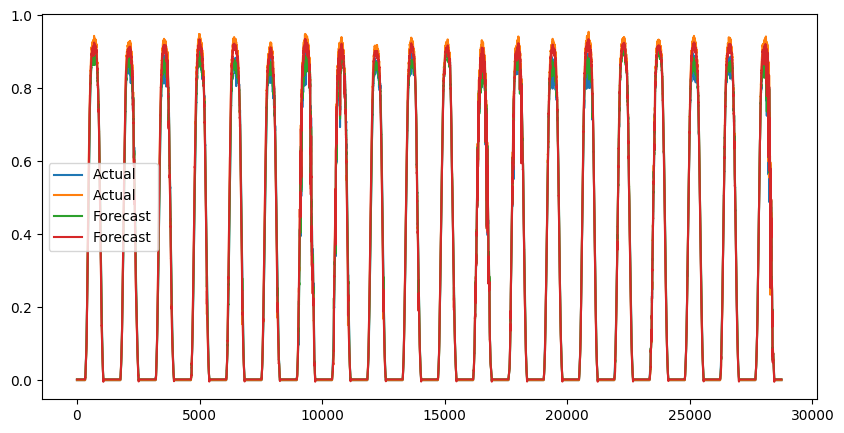

In [26]:
# Plot forecast and actual values for case 4
case4_model.eval()
case4_X_test = case4_X_test.permute(1, 0, 2)
case4_y_pred = case4_model(case4_X_test)
case4_y_pred = case4_y_pred.cpu().detach().numpy()
case4_y_test = case4_y_test.cpu().detach().numpy()

plt.figure(figsize = (10, 5))
plt.plot(case4_y_test, label='Actual')
plt.plot(case4_y_pred, label='Forecast')
plt.legend()
plt.show()

In [28]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to CUDA device
case5_model = case5_model.to(device)

# Define loss function and optimizer common for all cases
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(case5_model.parameters(), lr=0.001)

# Case 5

case5_num_epochs = 100
case5_batch_size = 64

# Move data to CUDA device and update data type
case5_X_train = torch.from_numpy(case5_X_train).type(torch.Tensor).to(device)
case5_y_train = torch.from_numpy(case5_y_train).type(torch.Tensor).to(device)
case5_X_test = torch.from_numpy(case5_X_test).type(torch.Tensor).to(device)
case5_y_test = torch.from_numpy(case5_y_test).type(torch.Tensor).to(device)

case5_train = torch.utils.data.TensorDataset(case5_X_train, case5_y_train)
case5_test = torch.utils.data.TensorDataset(case5_X_test, case5_y_test)

case5_train_loader = torch.utils.data.DataLoader(dataset=case5_train, batch_size=case5_batch_size, shuffle=False)
case5_test_loader = torch.utils.data.DataLoader(dataset=case5_test, batch_size=case5_batch_size, shuffle=False)

case5_train_loss = []
case5_test_loss = []

for epoch in range(case5_num_epochs):
    case5_running_loss = 0.0
    case5_running_test_loss = 0.0

    for i, (inputs, labels) in tqdm(enumerate(case5_train_loader)):
        optimizer.zero_grad()

        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case5_model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        case5_running_loss += loss.item()

    case5_train_loss.append(case5_running_loss / len(case5_train_loader))

    for i, (inputs, labels) in tqdm(enumerate(case5_test_loader)):
        # Move inputs and labels to CUDA device
        inputs = inputs.permute(1, 0, 2).to(device)
        labels = labels.to(device)

        outputs = case5_model(inputs)

        loss = criterion(outputs, labels)

        case5_running_test_loss += loss.item()

    case5_test_loss.append(case5_running_test_loss / len(case5_test_loader))

    if epoch % 10 == 0:
        print('Epoch: {} | Train Loss: {} | Test Loss: {}'.format(epoch + 1, round(case5_train_loss[-1], 6), round(case5_test_loss[-1], 6)))


1800it [00:03, 567.77it/s]
450it [00:00, 1128.91it/s]


Epoch: 1 | Train Loss: 0.010397 | Test Loss: 0.001442


1800it [00:03, 478.11it/s]
450it [00:00, 1167.45it/s]
1800it [00:03, 578.97it/s]
450it [00:00, 1145.61it/s]
1800it [00:03, 575.20it/s]
450it [00:00, 1158.76it/s]
1800it [00:03, 569.02it/s]
450it [00:00, 1153.48it/s]
1800it [00:03, 579.49it/s]
450it [00:00, 1160.30it/s]
1800it [00:03, 581.68it/s]
450it [00:00, 1170.28it/s]
1800it [00:03, 547.73it/s]
450it [00:00, 1160.55it/s]
1800it [00:03, 568.09it/s]
450it [00:00, 830.77it/s] 
1800it [00:03, 579.45it/s]
450it [00:00, 1138.50it/s]
1800it [00:03, 549.94it/s]
450it [00:00, 1159.47it/s]


Epoch: 11 | Train Loss: 0.000463 | Test Loss: 9.9e-05


1800it [00:03, 522.13it/s]
450it [00:00, 908.30it/s] 
1800it [00:03, 580.26it/s]
450it [00:00, 1142.39it/s]
1800it [00:03, 533.48it/s]
450it [00:00, 1029.39it/s]
1800it [00:03, 579.28it/s]
450it [00:00, 1152.58it/s]
1800it [00:03, 579.78it/s]
450it [00:00, 1148.20it/s]
1800it [00:03, 576.49it/s]
450it [00:00, 1143.23it/s]
1800it [00:03, 576.99it/s]
450it [00:00, 1148.80it/s]
1800it [00:03, 575.32it/s]
450it [00:00, 1140.44it/s]
1800it [00:03, 581.12it/s]
450it [00:00, 1156.84it/s]
1800it [00:03, 565.90it/s]
450it [00:00, 1157.90it/s]


Epoch: 21 | Train Loss: 0.00025 | Test Loss: 7.4e-05


1800it [00:03, 581.52it/s]
450it [00:00, 1165.19it/s]
1800it [00:03, 583.29it/s]
450it [00:00, 1165.14it/s]
1800it [00:03, 584.06it/s]
450it [00:00, 1046.91it/s]
1800it [00:03, 586.68it/s]
450it [00:00, 1158.33it/s]
1800it [00:03, 566.74it/s]
450it [00:00, 1237.92it/s]
1800it [00:04, 361.91it/s]
450it [00:00, 1244.63it/s]
1800it [00:05, 357.94it/s]
450it [00:00, 1238.57it/s]
1800it [00:05, 355.44it/s]
450it [00:00, 1243.81it/s]
1800it [00:05, 354.16it/s]
450it [00:00, 1248.07it/s]
1800it [00:05, 353.73it/s]
450it [00:00, 1247.74it/s]


Epoch: 31 | Train Loss: 0.000231 | Test Loss: 5.3e-05


1800it [00:05, 352.88it/s]
450it [00:00, 1243.14it/s]
1800it [00:05, 354.43it/s]
450it [00:00, 1245.36it/s]
1800it [00:05, 353.26it/s]
450it [00:00, 1244.67it/s]
1800it [00:05, 354.36it/s]
450it [00:00, 1247.11it/s]
1800it [00:05, 352.85it/s]
450it [00:00, 1242.88it/s]
1800it [00:05, 353.18it/s]
450it [00:00, 1245.10it/s]
1800it [00:05, 352.68it/s]
450it [00:00, 1241.53it/s]
1800it [00:05, 353.74it/s]
450it [00:00, 1247.84it/s]
1800it [00:05, 354.26it/s]
450it [00:00, 1245.10it/s]
1800it [00:05, 354.38it/s]
450it [00:00, 1246.81it/s]


Epoch: 41 | Train Loss: 0.000204 | Test Loss: 0.00016


1800it [00:05, 353.29it/s]
450it [00:00, 1244.71it/s]
1800it [00:05, 354.06it/s]
450it [00:00, 1246.09it/s]
1800it [00:05, 354.05it/s]
450it [00:00, 1244.01it/s]
1800it [00:05, 354.45it/s]
450it [00:00, 1244.43it/s]
1800it [00:05, 355.06it/s]
450it [00:00, 1247.27it/s]
1800it [00:05, 354.02it/s]
450it [00:00, 1247.38it/s]
1800it [00:05, 353.87it/s]
450it [00:00, 1250.07it/s]
1800it [00:05, 353.09it/s]
450it [00:00, 1246.69it/s]
1800it [00:05, 354.10it/s]
450it [00:00, 1249.50it/s]
1800it [00:05, 353.41it/s]
450it [00:00, 1243.96it/s]


Epoch: 51 | Train Loss: 0.000199 | Test Loss: 4.3e-05


1800it [00:05, 354.21it/s]
450it [00:00, 1245.66it/s]
1800it [00:05, 354.99it/s]
450it [00:00, 1246.37it/s]
1800it [00:05, 356.26it/s]
450it [00:00, 1245.97it/s]
1800it [00:05, 354.12it/s]
450it [00:00, 1245.45it/s]
1800it [00:05, 353.92it/s]
450it [00:00, 1245.95it/s]
1800it [00:05, 355.85it/s]
450it [00:00, 1243.13it/s]
1800it [00:05, 355.00it/s]
450it [00:00, 1242.25it/s]
1800it [00:05, 354.69it/s]
450it [00:00, 1246.29it/s]
1800it [00:05, 354.69it/s]
450it [00:00, 1244.93it/s]
1800it [00:05, 355.28it/s]
450it [00:00, 1242.65it/s]


Epoch: 61 | Train Loss: 0.000194 | Test Loss: 4e-05


1800it [00:05, 355.71it/s]
450it [00:00, 1248.51it/s]
1800it [00:05, 355.32it/s]
450it [00:00, 1247.36it/s]
1800it [00:05, 355.84it/s]
450it [00:00, 1248.15it/s]
1800it [00:05, 355.67it/s]
450it [00:00, 1245.65it/s]
1800it [00:05, 352.96it/s]
450it [00:00, 1245.60it/s]
1800it [00:05, 353.12it/s]
450it [00:00, 1246.26it/s]
1800it [00:05, 354.06it/s]
450it [00:00, 1244.57it/s]
1800it [00:05, 353.18it/s]
450it [00:00, 1244.61it/s]
1800it [00:05, 353.20it/s]
450it [00:00, 1246.28it/s]
1800it [00:05, 353.78it/s]
450it [00:00, 1246.27it/s]


Epoch: 71 | Train Loss: 0.000174 | Test Loss: 4e-05


1800it [00:05, 354.58it/s]
450it [00:00, 1240.31it/s]
1800it [00:05, 353.10it/s]
450it [00:00, 1246.15it/s]
1800it [00:05, 354.40it/s]
450it [00:00, 1242.15it/s]
1800it [00:05, 353.01it/s]
450it [00:00, 1247.44it/s]
1800it [00:05, 353.58it/s]
450it [00:00, 1249.12it/s]
1800it [00:05, 354.42it/s]
450it [00:00, 1248.13it/s]
1800it [00:05, 353.10it/s]
450it [00:00, 1241.73it/s]
1800it [00:05, 353.82it/s]
450it [00:00, 1244.18it/s]
1800it [00:05, 357.76it/s]
450it [00:00, 1243.71it/s]
1800it [00:05, 359.22it/s]
450it [00:00, 1244.09it/s]


Epoch: 81 | Train Loss: 0.012564 | Test Loss: 0.000102


1800it [00:05, 357.15it/s]
450it [00:00, 1244.06it/s]
1800it [00:05, 356.46it/s]
450it [00:00, 1246.62it/s]
1800it [00:05, 356.00it/s]
450it [00:00, 1241.34it/s]
1800it [00:05, 355.98it/s]
450it [00:00, 1242.38it/s]
1800it [00:05, 357.14it/s]
450it [00:00, 1248.82it/s]
1800it [00:05, 356.95it/s]
450it [00:00, 1244.43it/s]
1800it [00:05, 357.58it/s]
450it [00:00, 1242.30it/s]
1800it [00:05, 356.57it/s]
450it [00:00, 1245.77it/s]
1800it [00:05, 356.48it/s]
450it [00:00, 1245.30it/s]
1800it [00:05, 359.63it/s]
450it [00:00, 1243.06it/s]


Epoch: 91 | Train Loss: 0.00014 | Test Loss: 4.2e-05


1800it [00:05, 356.60it/s]
450it [00:00, 1236.86it/s]
1800it [00:05, 357.62it/s]
450it [00:00, 1246.10it/s]
1800it [00:05, 356.64it/s]
450it [00:00, 1243.70it/s]
1800it [00:05, 356.49it/s]
450it [00:00, 1244.02it/s]
1800it [00:05, 355.89it/s]
450it [00:00, 1272.03it/s]
1800it [00:05, 355.94it/s]
450it [00:00, 1234.89it/s]
1800it [00:05, 357.88it/s]
450it [00:00, 1241.02it/s]
1800it [00:05, 357.00it/s]
450it [00:00, 1233.61it/s]
1800it [00:05, 357.50it/s]
450it [00:00, 1241.38it/s]


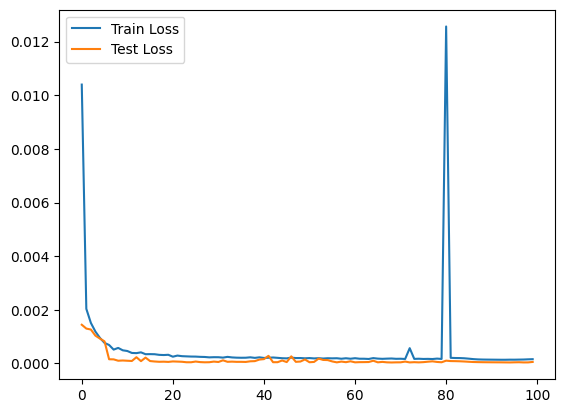

In [29]:
# Plot train and test loss for case 5
plt.figure()
plt.plot(case5_train_loss, label='Train Loss')
plt.plot(case5_test_loss, label='Test Loss')
plt.legend()
plt.show()

In [30]:
# Save model
torch.save(case5_model.state_dict(), 'case5_model.pth')

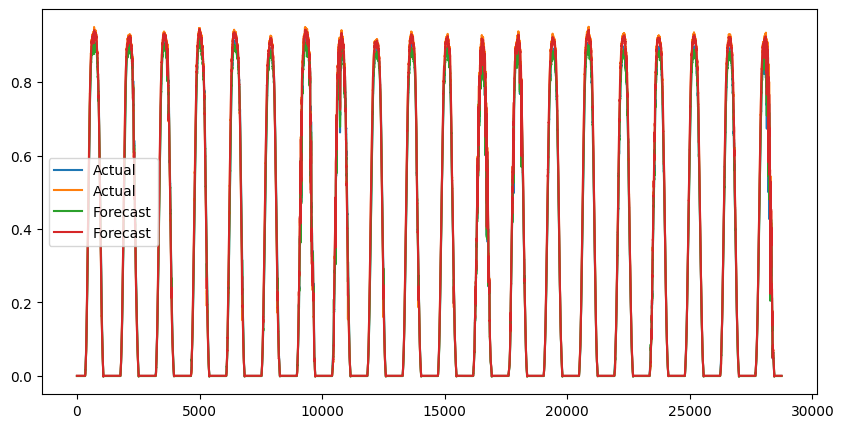

In [31]:
# Plot forecast and actual values for case 5
case5_model.eval()
case5_X_test = case5_X_test.permute(1, 0, 2)
case5_y_pred = case5_model(case5_X_test)
case5_y_pred = case5_y_pred.cpu().detach().numpy()
case5_y_test = case5_y_test.cpu().detach().numpy()

plt.figure(figsize = (10, 5))
plt.plot(case5_y_test, label='Actual')
plt.plot(case5_y_pred, label='Forecast')
plt.legend()
plt.show()